# Unsupervised Machine Learning with Quantum Approximate Optimization Algorithm

This shows how a quantum optimization algorithm such as QAOA can solving the Max-Cut problem can be used for unsupervised machine learning clustering problem. The current solution works on  small less than 50 qubit NISQ quantum computers. 

Data: Motor Trend Cars dataset. See other notebook for original Iris dataset results

Both classical and quantum methods are used to classify the Motor Trend cars dataset. First, the classical k-means clustering algorithm is walked through. Second, the max-cut problem is mapped to an Ising Hamiltonian and solved using QAOA. This notebook is based on work done by <a href="https://ajrazander.github.io/2019/11/07/Quantum-Max-cut-vs-K-means.html"> AJ Razander</a>, this <a href = "https://www.kaggle.com/efeergun96/unsupervised-learning-on-iris"> kaggle tutorial on k-means</a>, this <a href = "https://github.com/qiskit-community/qiskit-qcgpu-provider/blob/master/examples/aqua/Max-Cut.ipynb"> qiskit tutorial on max-cut </a>, and the paper <a href="https://arxiv.org/abs/1712.05771"> Unsupervised Machine Learning on a Hybrid Quantum Computer</a> were helpful aids in constructing this notebook and make for interesting reading.

This paper modifies the original notebook by using a different dataset, and updating the code to make use of quantum model so it is works with modern versions of Qiskit.

In [2]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

# Quantum Computing packages
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.optimization.applications.ising import max_cut
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.optimization.applications.ising import graph_partition
from qiskit.optimization.applications.ising.common import random_graph, sample_most_likely

### Import Motor Trend Cars dataset from GitHub

In [4]:
# Import CSV mtcars
cars = pd.read_csv('https://gist.githubusercontent.com/ZeccaLehn/4e06d2575eb9589dbe8c365d61cb056c/raw/64f1660f38ef523b2a1a13be77b002b98665cdfe/mtcars.csv')
# Edit element of column header
cars.rename(columns={'Unnamed: 0':'car'}, inplace=True)

### Classify cars as "Sport" or "Economy" and reduce size of data set for use on quantum computer

In [8]:
cars2 = cars
cars2['sport'] = cars2['car'].isin(['Maserati Bora', 'Ford Pantera L', 'Pontiac Firebird', 'Camaro Z28', 
                             'AMC Javelin', 'Dodge Challenger'])

cars_filt = cars2['car'].isin(['Maserati Bora','Ford Pantera L', 'Pontiac Firebird', 'Camaro Z28', 
                             'AMC Javelin', 'Dodge Challenger', 'Datsun 710', 'Fiat X1-9', 
                             'Volvo 142E', 'Toyota Corona', 'Toyota Corolla', 'Honda Civic', ' Fiat 128'])
        
cars3= cars2[cars_filt]

cars3['type'] = np.where(cars3['sport'] == True, "sport", 'economy') 
cars3 = cars3[['car','type', 'disp', 'qsec', 'mpg', 'hp']]
cars_unsup =  cars3[['disp', 'qsec', 'mpg', 'hp']]
cars3

<ipython-input-8-4327e5502069>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cars3['type'] = np.where(cars3['sport'] == True, "sport", 'economy')


,car,type,disp,qsec,mpg,hp
2,Datsun 710,economy,108.0,18.61,22.8,93
18,Honda Civic,economy,75.7,18.52,30.4,52
19,Toyota Corolla,economy,71.1,19.90,33.9,65
20,Toyota Corona,economy,120.1,20.01,21.5,97
21,Dodge Challenger,sport,318.0,16.87,15.5,150
22,AMC Javelin,sport,304.0,17.30,15.2,150
23,Camaro Z28,sport,350.0,15.41,13.3,245
24,Pontiac Firebird,sport,400.0,17.05,19.2,175
25,Fiat X1-9,economy,79.0,18.90,27.3,66
28,Ford Pantera L,sport,351.0,14.50,15.8,264


### Visualize car data between Economy and Sports cars
Shows differences in data between economy and sport cars based on engine displacment, quarter mile speed, miles per gallon, and horse-power.

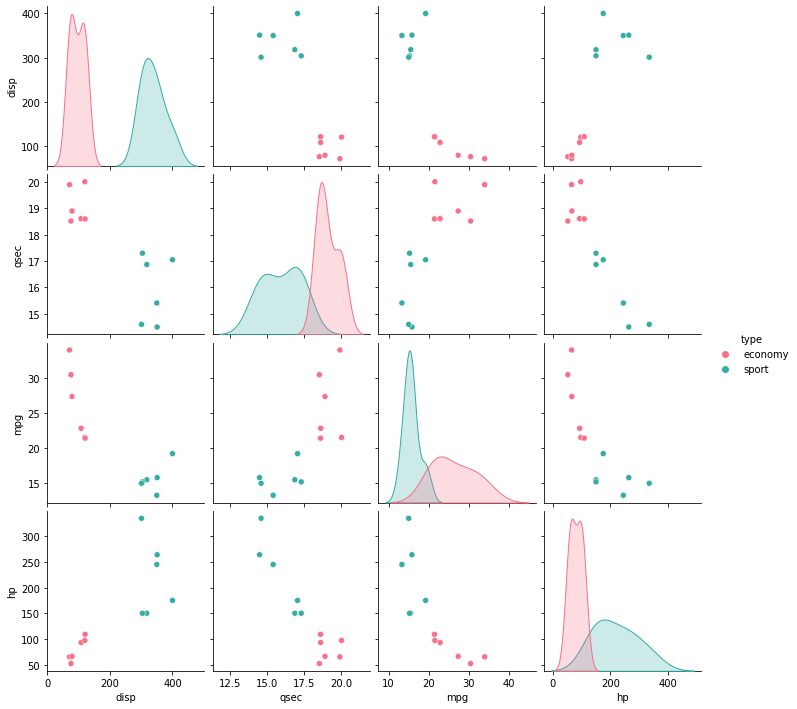

In [9]:
# View data with known labels as a control to compare future clustering done by k-means and QAOA
sns.pairplot(data=cars3, hue="type", palette="husl", vars=["disp", "qsec", "mpg", "hp"])
plt.show()

The k-means algorithm is an unsupervised machine learning method. K-means will cluster data into k groups based on minimizing each cluster’s sum-of-sqaures also known as inertia. 

The optimal number of clusters k is known for this data (k=2) since the reduced dataset only contains two species. However, we will assume that is unknown. Comparison between the actual species label and how k-means clusters the data will be a performance metric for this and the quantum approach. Since the optimal k is unknown, let’s use the elbow rule to determine the optimal k. 

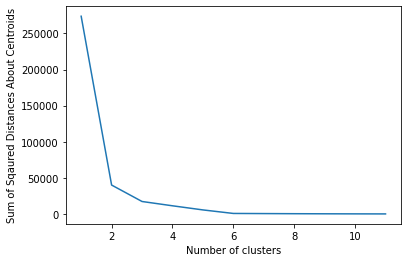

In [10]:
# Use k-means as classical unsupervised learning method (compare to quantum method later)

# Use elbow rule to choose optimal k
dis = []
K = range(1,len(cars_unsup))
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(cars_unsup)
    dis.append(kmeans.inertia_)

# Visualize Optimal k
plt.plot(K,dis)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Sqaured Distances About Centroids')
plt.show()

The optimal value appears to be 2, since that is where the angle of the line changes the most. Let's fit then visualize the k-means algorithm with the optimal k.

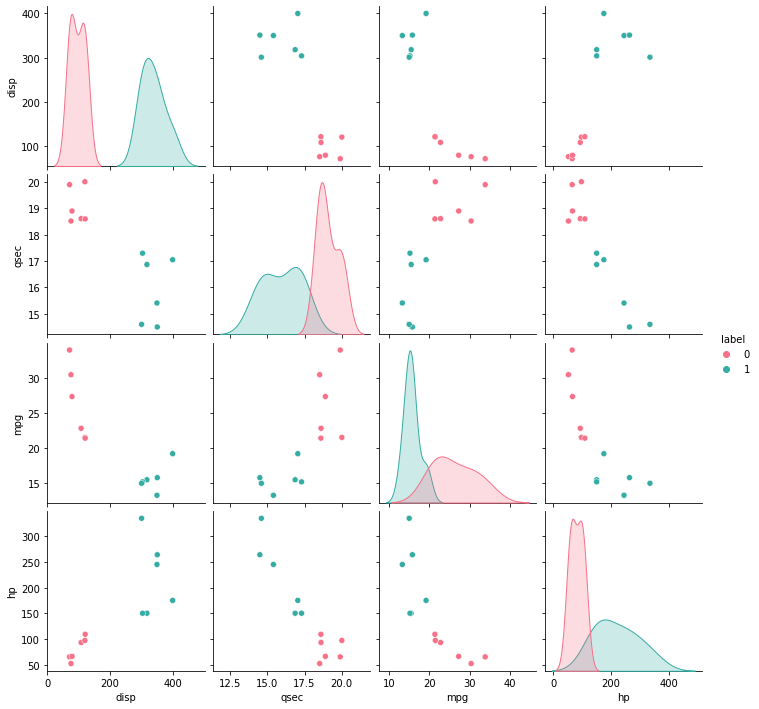

In [11]:
# Use optimal k for final k-means model
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(cars_unsup)

# Add k-means labeling to dataframe for later comparison
cars3['label'] = kmeans.labels_

# Visualize clustering done by k-means algorithm
sns.pairplot(data=cars3, hue='label', palette="husl", vars=["disp", "qsec", "mpg", "hp"])
plt.show()

The plots looks nearly identical to the reduced dataset. This is directly confirmed below where we see economy cars are 100% in one cluster and sports cars are 100% in the other cluster.

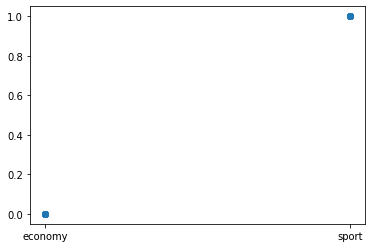

Updated dataframe with label classification:
"Average" label classification:
type
economy    0.0
sport      1.0
Name: label, dtype: float64


,car,type,disp,qsec,mpg,hp,label
2,Datsun 710,economy,108.0,18.61,22.8,93,0
18,Honda Civic,economy,75.7,18.52,30.4,52,0
19,Toyota Corolla,economy,71.1,19.90,33.9,65,0
20,Toyota Corona,economy,120.1,20.01,21.5,97,0
21,Dodge Challenger,sport,318.0,16.87,15.5,150,1
22,AMC Javelin,sport,304.0,17.30,15.2,150,1
23,Camaro Z28,sport,350.0,15.41,13.3,245,1
24,Pontiac Firebird,sport,400.0,17.05,19.2,175,1
25,Fiat X1-9,economy,79.0,18.90,27.3,66,0
28,Ford Pantera L,sport,351.0,14.50,15.8,264,1


In [15]:
# Calculate percent of miss labeled data points
plt.scatter(cars3['type'], cars3['label'])
plt.show()
print('\"Average\" label classification:')
print(cars3.groupby(['type']).sum()['label'] / cars3.groupby(['type']).count()['label'])
print('Updated dataframe with label classification:')
cars3


With k = 2, the k-means algorithm clustering is 100% accurate on this subset of the Motor Trend cars dataset! Let’s see how the quantum computer fairs.

# Quantum Clustering Approach
One approach to unsupervised quantum machine learning is to map the problem to a graph optimization problem (specifically max-cut in this notebook). The graph optimization problem can then be mapped to a cost Hamiltonian, which can quickly be solved by a quantum computer.

The first step in mapping data to a graph is calculating the pairwise “distances” between each data point. These distances will weight the edges of the graph. There are different ways to measure “distance.” We will use the vector magnitude to measure distance. Again, we’ll be using a subset of the Motor Trend cars dataset.

In [16]:
# Remove species labels
data = cars3.loc[:,['disp', 'qsec', 'mpg', 'hp']]

# Get number of data entries
n_instances = len(data)

# Convert dataframe into array
data_array = data.values

# Calculate pairwise L2-norms
w = np.zeros((n_instances, n_instances))
for i in range(0,n_instances):
    for j in range(0,n_instances):
        w[i, j] = np.linalg.norm(data_array[i]-data_array[j])

print('Weight matrix size:',w.shape)

Weight matrix size: (12, 12)


### Map the Max-cut problem to a Cost Hamiltonian

To separate the graph into clusters, the graph is cut with a max-cut: meaning the graph is separated in two while maximizing total weight of the ‘cut’ edges. This is an NP-hard problem. However, it maps to an Ising model, so there is a quantum speedup. Now that the max-cut is mapped to the Ising Hamiltonian, a quantum computer can efficiently find the max-cut by finding the ground state of the Ising Hamiltonian. 

More details on the derivation can be found in the paper <a href="https://arxiv.org/abs/1712.05771"> Unsupervised Machine Learning on a Hybrid Quantum Computer </a>

### Solve the Max-cut Problem with QAOA
Qiskit will be used to implement QAOA. QAOA is a quantum optimizer that will find the ground state of the cost Hamiltonian.

In [17]:
# QAOA hyperparameters and initialization
p = 2  # Number of adiabatic steps must be > 0, modified from original value of 1 for better fit
optimizer = COBYLA()
qubit_ops, offset = max_cut.get_operator(w)
qaoa = QAOA(qubit_ops, optimizer, p )

# Initialize quantum simulator
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=100)

In [18]:
# Execute QAOA on quantum simulator
result = qaoa.run(quantum_instance)

# Extract clustering solution from result variable
x = sample_most_likely(result['eigvecs'][0])

# Show cluster results
print('cluster solution:', max_cut.get_graph_solution(x))

cluster solution: [0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0.]


/opt/conda/lib/python3.8/site-packages/qiskit/aqua/algorithms/minimum_eigen_solvers/minimum_eigen_solver.py:150: DeprecationWarning: eigvecs deprecated, use eigenstate property.
  warnings.warn('eigvecs deprecated, use eigenstate property.', DeprecationWarning)


"Average" label classification:
type
economy    0.0
sport      1.0
Name: qlabel, dtype: float64


,car,type,disp,qsec,mpg,hp,label,qlabel
0,Datsun 710,economy,108.0,18.61,22.8,93,0,0
1,Honda Civic,economy,75.7,18.52,30.4,52,0,0
2,Toyota Corolla,economy,71.1,19.90,33.9,65,0,0
3,Toyota Corona,economy,120.1,20.01,21.5,97,0,0
4,Dodge Challenger,sport,318.0,16.87,15.5,150,1,1
5,AMC Javelin,sport,304.0,17.30,15.2,150,1,1
6,Camaro Z28,sport,350.0,15.41,13.3,245,1,1
7,Pontiac Firebird,sport,400.0,17.05,19.2,175,1,1
8,Fiat X1-9,economy,79.0,18.90,27.3,66,0,0
9,Ford Pantera L,sport,351.0,14.50,15.8,264,1,1


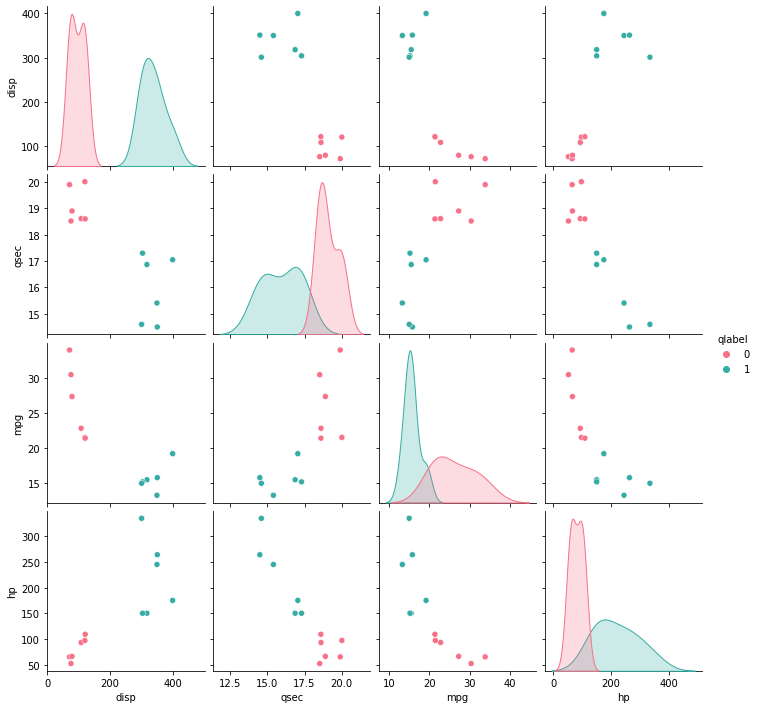

In [20]:
# Extract labels and include them in df_sub
labels = pd.DataFrame(max_cut.get_graph_solution(x),columns=['qlabel'])
cars3.reset_index(drop=True, inplace=True)
cars3['qlabel'] = labels
cars3['qlabel'] = cars3['qlabel'].astype(np.int64)

#custom_map = {0: 'zero', 1: 'one'}
#cars3['qlabel'] = cars3['qlabel'].map(custom_map)

# Show data by cluster
sns.pairplot(data=cars3, hue='qlabel', vars=["disp", "qsec", "mpg", "hp"], palette="husl")
#plt.show()

# Display cluster label mean by species
print('\"Average\" label classification:')
print(cars3.groupby(['type']).sum()['qlabel'] / cars3.groupby(['type']).count()['qlabel'])
cars3

The plots looks identical to the reduced dataset–again! This is directly confirmed by the “average” label classification. All of economy cars are in one cluster and all of sports cars are in the other cluster!

## References


http://kth.diva-portal.org/smash/get/diva2:1381305/FULLTEXT01.pdf

https://arxiv.org/pdf/1909.12183.pdf

https://arxiv.org/abs/1812.03584

Presentation: https://www.beautiful.ai/player/-LvzAKfOvD3rKTTOWTcN/Q-means
